# Задание 6: Рекуррентные нейронные сети (RNNs)

Это задание адаптиповано из Deep NLP Course at ABBYY (https://github.com/DanAnastasyev/DeepNLP-Course) с разрешения автора - Даниила Анастасьева. Спасибо ему огромное!

In [2]:
# !pip3 -qq install torch==0.4.1
# !pip3 -qq install bokeh==0.13.0
# !pip3 -qq install gensim==3.6.0
# !pip3 -qq install nltk
# !pip3 -qq install scikit-learn==0.20.2

ERROR: Could not find a version that satisfies the requirement torch==0.4.1
ERROR: No matching distribution found for torch==0.4.1


In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

# Рекуррентные нейронные сети (RNNs)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [2]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\BobPc\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\BobPc\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


Пример размеченного предложения:

In [3]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [4]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


Построим маппинги из слов в индекс и из тега в индекс:


In [5]:
# Get indexes for words in train_data
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind for ind, word in enumerate(words, 1)}
# In word_to_index dictionary <pad> has index 0
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind for ind, tag in enumerate(tags, 1)}
# In tag_to_index dictionary <pad> has index 0
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'VERB', 'PRT', 'ADP', 'NUM', 'NOUN', 'ADV', 'CONJ', '.', 'ADJ', 'DET', 'X', 'PRON'}


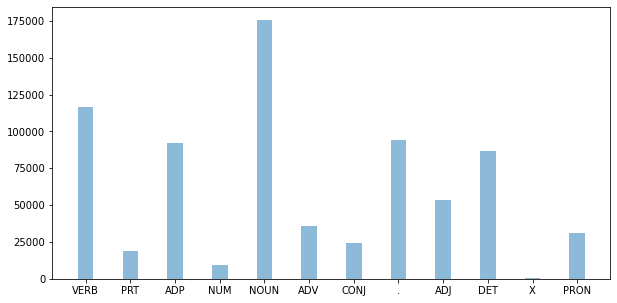

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter


tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))
bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [7]:
import nltk


default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

Accuracy of unigram tagger = 92.62%


Добавим вероятности переходов:

In [8]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [9]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger = 23.33%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:  
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [10]:
def convert_data(data, word2ind, tag2ind):
    # If word not in words dict then index 0
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [13]:
def iterate_batches(data, batch_size):
    '''
    This function-generator yields batches of X_batch and y_batch.
    Batch consists of sentences.
    In case all elements in batch must be regular sized, we pad by 0
    every sentence that less than maximum length sentence of batch.'''
    # Full X and Y of dataset
    X, y = data
    # Number of sentences
    n_samples = len(X)
    
    # Making indices of sentences and shuffling them
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    # Iterates over batches
    for start in range(0, n_samples, batch_size):
        # If the end of batch
        end = min(start + batch_size, n_samples)
        # Extacting indices of a current batch
        batch_indices = indices[start:end]
        # Maximum length of a sentence of batch
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        # Initializing batches (rows-words of a sentence, column-sentence of batch)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        # Iterating over batch indices
        for batch_ind, sample_ind in enumerate(batch_indices):
            # Assign a column exact words of a sentence, if len(sentece) < max(len(sentence)) zeros left
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
        # yield batch of X(sentences of words) and Y(POSes of words)    
        yield X_batch, y_batch

In [15]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 3))

print(X_batch.shape, y_batch.shape)
print(X_batch)

(24, 3) (24, 3)
[[ 8838. 37929.  5805.]
 [29209. 39911. 41109.]
 [ 7839.  6924. 37929.]
 [10885. 27385. 35898.]
 [35368.   562. 41109.]
 [14140.  6262. 27194.]
 [    0.  6137. 33331.]
 [    0.  4505. 34924.]
 [    0. 31860. 32457.]
 [    0. 14140. 12732.]
 [    0.     0. 37377.]
 [    0.     0.  9666.]
 [    0.     0.  7287.]
 [    0.     0. 40383.]
 [    0.     0. 24902.]
 [    0.     0.  9406.]
 [    0.     0. 27652.]
 [    0.     0. 33742.]
 [    0.     0.  1975.]
 [    0.     0. 13392.]
 [    0.     0.  6475.]
 [    0.     0. 23012.]
 [    0.     0. 32900.]
 [    0.     0. 14140.]]


**Задание** Реализуйте `LSTMTagger`:

In [16]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        # Hidden state dim of LSTM
        self.hidden_dim = lstm_hidden_dim
        
        # This layer embeds batch of sentences
        self.word_embedder = nn.Embedding(vocab_size, word_emb_dim)
        # LSTM takes embeddings dim and hiddens (dim of hidden state) as parameters
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count)
        # FC layer (hidden state to softmax), hidden state dim as input parameter
        self.fc = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        # By default hidden state and cell state are provided as zeros tensors in input of LSTM in torch
        # h0 = torch.zeros(1 * self.layers_count, inputs.shape[1], self.hidden_dim, requires_grad=True).cuda()
        # c0 = torch.zeros(1 * self.layers_count, inputs.shape[1], self.hidden_dim, requires_grad=True).cuda()
        # Embeddings inputs are indices of sentences in generated batch
        embeddings = self.word_embedder(inputs)
        # lstm inputs are input tensor of shape (Seq_len, batch_size, embed_size), (h and c are zeros tensors by default)
        # nn.Embedding returns correct dimension output
        # Output of LSTM contains output dim(Seq, Batch, Hidden_state) these are h_t for each t, also h_n, c_n
        lstm_out, (hn, cn) = self.lstm(embeddings)
        # FC layer to classification
        output = self.fc(lstm_out.view(-1, self.hidden_dim))    
        return output

In [17]:
a = torch.tensor([[[1, 2, 3, 4],
                   [5, 6, 7, 8]],
                  [[10, 12, 13, 14],
                   [15, 16, 17, 18]]])
a.shape

torch.Size([2, 2, 4])

In [18]:
a.view(-1, 4)

tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [10, 12, 13, 14],
        [15, 16, 17, 18]])

**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [21]:
def calc_accuracy(logits, gt):
    return torch.sum(torch.argmax(logits, dim=1) == gt.flatten()) / (gt.shape[0] * gt.shape[1])

In [25]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)

#<calc accuracy>
print('Accuracy: {}'.format(calc_accuracy(logits, y_batch)))

Accuracy: 0.0555555559694767


In [26]:
logits.shape

torch.Size([72, 13])

In [27]:
criterion = nn.CrossEntropyLoss()
# <calc loss>
loss = criterion(logits, y_batch.flatten())
print(loss)

tensor(2.5879, grad_fn=<NllLossBackward>)


In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [30]:
X_batch.flatten()

tensor([ 8838, 37929,  5805, 29209, 39911, 41109,  7839,  6924, 37929, 10885,
        27385, 35898, 35368,   562, 41109, 14140,  6262, 27194,     0,  6137,
        33331,     0,  4505, 34924,     0, 31860, 32457,     0, 14140, 12732,
            0,     0, 37377,     0,     0,  9666,     0,     0,  7287,     0,
            0, 40383,     0,     0, 24902,     0,     0,  9406,     0,     0,
        27652,     0,     0, 33742,     0,     0,  1975,     0,     0, 13392,
            0,     0,  6475,     0,     0, 23012,     0,     0, 32900,     0,
            0, 14140])

**Задание** Вставьте эти вычисление в функцию:

In [33]:
def compute_accuracy(logits_, X_batch_, y_batch_flatten_):
    # Applying mask of zeros of pads and making torch.argmax()
    masked = torch.argmax(logits_ * X_batch_.flatten().to(torch.bool)[:, None], dim=1)
    correct_cnt = torch.sum(masked == y_batch_flatten_)
    all_cnt = len(y_batch_flatten_)
    zeros = all_cnt - torch.count_nonzero(y_batch_flatten_)
    return correct_cnt - zeros, all_cnt - zeros

In [38]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train) # mode = True/False
    # batches_count = len(X) / batch_size
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                y_batch_flatten = LongTensor(y_batch.flatten())
                logits = model(X_batch)

                loss = criterion(logits, y_batch_flatten) # <calc loss>

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                cur_correct_count, cur_sum_count =  compute_accuracy(logits, X_batch, y_batch_flatten)
                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32, val_data=None, val_batch_size=None):
    
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')

In [39]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.30537, Accuracy = 73.12%: 100%|█████████████████████████████| 572/572 [00:10<00:00, 55.79it/s]
[1 / 50]   Val: Loss = 0.09350, Accuracy = 85.01%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 43.64it/s]
[2 / 50] Train: Loss = 0.10014, Accuracy = 90.15%: 100%|█████████████████████████████| 572/572 [00:09<00:00, 58.81it/s]
[2 / 50]   Val: Loss = 0.07753, Accuracy = 89.39%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 50.40it/s]
[3 / 50] Train: Loss = 0.06759, Accuracy = 93.28%: 100%|█████████████████████████████| 572/572 [00:09<00:00, 59.48it/s]
[3 / 50]   Val: Loss = 0.06571, Accuracy = 91.12%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 50.02it/s]
[4 / 50] Train: Loss = 0.05115, Accuracy = 94.88%: 100%|█████████████████████████████| 572/572 [00:09<00:00, 58.98it/s]
[4 / 50]   Val: Loss = 0.06430, Accuracy = 92.08%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 50.21it/s]
[5 / 50] Train: Loss = 0.04062, Accuracy

### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

In [41]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.68656, Accuracy = 78.40%: 100%|█████████████████████████████| 572/572 [00:09<00:00, 58.25it/s]
[1 / 50]   Val: Loss = 0.35818, Accuracy = 86.59%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 52.02it/s]
[2 / 50] Train: Loss = 0.27279, Accuracy = 91.00%: 100%|█████████████████████████████| 572/572 [00:09<00:00, 58.79it/s]
[2 / 50]   Val: Loss = 0.23387, Accuracy = 90.56%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 50.40it/s]
[3 / 50] Train: Loss = 0.18375, Accuracy = 93.94%: 100%|█████████████████████████████| 572/572 [00:09<00:00, 59.10it/s]
[3 / 50]   Val: Loss = 0.18429, Accuracy = 92.07%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 48.71it/s]
[4 / 50] Train: Loss = 0.13719, Accuracy = 95.42%: 100%|█████████████████████████████| 572/572 [00:09<00:00, 58.36it/s]
[4 / 50]   Val: Loss = 0.16457, Accuracy = 92.75%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 51.00it/s]
[5 / 50] Train: Loss = 0.10683, Accuracy

**Задание** Посчитайте качество модели на тесте. Ожидается результат лучше бейзлайна!

In [42]:
test_loss, test_accuracy = do_epoch(model, criterion, (X_test, y_test), 64, name='Test') # Better than baseline

 Test Loss = 0.31103, Accuracy = 93.61%: 100%|██████████████████████████████████████| 224/224 [00:01<00:00, 157.91it/s]


### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png)  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

In [43]:
class BILSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        # Hidden state dim of LSTM
        self.hidden_dim = lstm_hidden_dim
        
        # This layer embeds batch of sentences
        self.word_embedder = nn.Embedding(vocab_size, word_emb_dim)
        # LSTM takes embeddings dim and hiddens (dim of hidden state) as parameters
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_coun, bidirectional=True)
        # FC layer (hidden state to softmax) (lstm output -> POS), hidden state dim as input parameter
        self.fc = nn.Linear(lstm_hidden_dim * 2, tagset_size)

    def forward(self, inputs):
        # By default hidden state and cell state are provided as zeros tensors in input of LSTM in torch
        # Embeddings inputs are indices of sentences
        embeddings = self.word_embedder(inputs)
        # lstm inputs are input tensor of shape (Seq_len, batch_size, embed_size), (h and c are zeros tensors by default)
        # Output of LSTM contains output dim(Seq, Batch, Hidden_state) these are h_t for each t, h_n, c_n
        lstm_out, (hn, cn) = self.lstm(embeddings)
        # FC layer to classification
        output = self.fc(lstm_out.view(-1, self.hidden_dim * 2))    
        return output

### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [44]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

C:\Users\BobPc\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Построим подматрицу для слов из нашей тренировочной выборки:

In [45]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


In [46]:
embeddings.shape

(45441, 100)

**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [47]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        self.hidden_state_size = lstm_hidden_dim
        self.embedder = nn.Embedding.from_pretrained(FloatTensor(embeddings))
        self.lstm = nn.LSTM(embeddings.shape[1], lstm_hidden_dim, lstm_layers_count)
        self.fc = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        output = self.embedder(inputs)
        # hn and cn are final states of each batch
        output, (hn, cn) = self.lstm(output)
        # output remains order as embeddings
        # Right order to use with flatten y_batch
        output = self.fc(output.view(-1, self.hidden_state_size))
        return output

In [183]:
model = LSTMTaggerWithPretrainedEmbs(
    embeddings=embeddings,
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.75122, Accuracy = 78.31%: 100%|████████████████████████████| 572/572 [00:04<00:00, 117.05it/s]
[1 / 50]   Val: Loss = 0.36852, Accuracy = 87.80%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 66.69it/s]
[2 / 50] Train: Loss = 0.28489, Accuracy = 91.51%: 100%|████████████████████████████| 572/572 [00:04<00:00, 119.56it/s]
[2 / 50]   Val: Loss = 0.25338, Accuracy = 90.79%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 71.85it/s]
[3 / 50] Train: Loss = 0.21013, Accuracy = 93.49%: 100%|████████████████████████████| 572/572 [00:04<00:00, 119.79it/s]
[3 / 50]   Val: Loss = 0.20745, Accuracy = 91.98%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 72.25it/s]
[4 / 50] Train: Loss = 0.17455, Accuracy = 94.46%: 100%|████████████████████████████| 572/572 [00:04<00:00, 118.28it/s]
[4 / 50]   Val: Loss = 0.18250, Accuracy = 92.74%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 68.44it/s]
[5 / 50] Train: Loss = 0.15355, Accuracy

**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

Добейтесь качества лучше прошлых моделей.

In [184]:
do_epoch(model, criterion, (X_test, y_test), 128, name='Test') # Better than baseline

 Test Loss = 0.12527, Accuracy = 95.97%: 100%|██████████████████████████████████████| 112/112 [00:00<00:00, 148.04it/s]


(0.12526794629437582, tensor(0.9597, device='cuda:0'))